In [1]:
import os, sys
import pandas as pd
import numpy as np

#Plot settings
from coffea import hist
from coffea.processor import defaultdict_accumulator

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#Just to efficiently save plots
plot_dir = "/u/gu/dhoang/ldmx_plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")

save_path = plot_dir + dt_string
print("Saving plot to: ", save_path)

# 2D trigger simulation
def find_pt_indx(pt, pt_edges):
    
    if pt >= pt_edges[-1]:
        pt_indx = -1
    elif pt <= pt_edges[0]:
        pt_indx = 0
    else:
        pt_indx = np.argmax((pt >= pt_edges[:-1]) & (pt <= pt_edges[1:]))
    
    return pt_indx

def find_e_indx(E, e_edges):
    
    if E >= e_edges[-1]:
        e_indx = -1
    elif E <= e_edges[0]:
        e_indx = 0
    else:
        e_indx = np.argmax((E >= e_edges[:-1]) & (E <= e_edges[1:]))
    
    return e_indx

def trigger_weight_2D(pt, E, mode = 'loose'):
    
    trigger_weight = np.load("loose_trigger_3500MeV.npy")
    
    if E > 3.5:
        return 0.
    
    pt_edges = np.asarray([0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0])/1000.
    e_edges = np.asarray([0.0, 500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0])/1000.
    
    #Find the index
    pt_indx = None
    e_indx = None
    
    pt_indx = find_pt_indx(pt, pt_edges)
    e_indx = find_e_indx(E, e_edges)
    
    if np.isnan(trigger_weight[pt_indx, e_indx]):
        return 0.
    else:
        return float(trigger_weight[pt_indx, e_indx]) 

Saving plot to:  /u/gu/dhoang/ldmx_plot/11-04-2021


## 2. Processor

In [2]:
hists = {}

#Leading lepton stuffs
hists["lepton_pt"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Lepton $p_{T}$ [GeV/c]", 20, 0, 1))
hists["lepton_e"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Lepton E [GeV]", 20, 0, 4))
hists["lepton_theta"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("theta", r"Final State Lepton $\theta$ [rad]", 20, 0, 2))
#Leading proton stuffs
hists["p1_ke"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Proton KE [GeV]", 20, 0, 4))
hists["p1_theta"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("theta", r"Final State Proton $\theta$ [rad]", 20, 0, 2))

#Leading neutron stuffs
hists["n1_ke"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Neutron KE [GeV]", 20, 0, 4))
hists["n1_theta"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("theta", r"Final State Neutron $\theta$ [rad]", 20, 0, 2))

In [3]:
def processor(file_name, config_mode = 'loose'):
    
    gst_df = pd.read_hdf(file_name, key="gst_df")

    query='index' #all
    df=gst_df.query(query)
    
    #Varibale parameters
    wght="MFP_pi"
    sigma=1
    units="GeV/c"
     
    #2D trigger simulation
    trigger_weights = df.apply(lambda x: trigger_weight_2D(x.ptl, x.El, mode = config_mode), axis = 1)
    
    CV_weight = (df["wght"]*trigger_weights).to_numpy()
    plus_sigma_weight = (df["wght_%s_p%d"%(wght,sigma)]*trigger_weights).to_numpy()
    minus_sigma_weight =  (df["wght_%s_n%d"%(wght,sigma)]*trigger_weights).to_numpy()
    
    #--------------------LEADING LEPTONS
    #Lepton's pT
    lepton_pt = df['ptl'].to_numpy()
    
    hists["lepton_pt"].fill(sample = 'CV', pt = lepton_pt, weight = CV_weight)
    
    hists["lepton_pt"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), pt = lepton_pt,
                            weight= plus_sigma_weight)
    
    hists["lepton_pt"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), pt = lepton_pt,
                            weight= minus_sigma_weight)
    
    #Energy of lepton
    lepton_e = df['El'].to_numpy()
    hists["lepton_e"].fill(sample = 'CV', e = lepton_e, weight = CV_weight)
    
    hists["lepton_e"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), e = lepton_e,
                            weight= plus_sigma_weight)
    
    hists["lepton_e"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), e = lepton_e,
                            weight= minus_sigma_weight)
    
    #Lepton angle
    lepton_theta = df['thetal'].to_numpy()
    hists["lepton_theta"].fill(sample = 'CV', theta = lepton_theta, weight = CV_weight)
    
    hists["lepton_theta"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), theta = lepton_theta,
                            weight= plus_sigma_weight)
    
    hists["lepton_theta"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), theta = lepton_theta,
                            weight= minus_sigma_weight)
    
    #--------------------LEADING PROTONS
    #Proton Kinetic Energy
    proton_ke = df['ke_p1'].to_numpy()
    hists["p1_ke"].fill(sample = 'CV', ke = proton_ke, weight = CV_weight)
    hists["p1_ke"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), ke = proton_ke,
                       weight= plus_sigma_weight)
    hists["p1_ke"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), ke = proton_ke,
                        weight= minus_sigma_weight)
    
    #Proton theta
    p1_theta = df['thetaz_p1'].to_numpy()
    hists["p1_theta"].fill(sample = 'CV', theta = p1_theta, weight = CV_weight)
    
    hists["p1_theta"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), theta = p1_theta,
                            weight= plus_sigma_weight)
    
    hists["p1_theta"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), theta = p1_theta,
                            weight= minus_sigma_weight)
    
    #--------------------LEADING NEUTRONs
    #Proton Kinetic Energy
    neutron_ke = df['ke_n1'].to_numpy()
    hists["n1_ke"].fill(sample = 'CV', ke = neutron_ke, weight = CV_weight)
    hists["n1_ke"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), ke = neutron_ke,
                       weight= plus_sigma_weight)
    hists["n1_ke"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), ke = neutron_ke,
                        weight= minus_sigma_weight)
    
    #neutron theta
    n1_theta = df['thetaz_n1'].to_numpy()
    hists["n1_theta"].fill(sample = 'CV', theta = n1_theta, weight = CV_weight)
    
    hists["n1_theta"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), theta = n1_theta,
                            weight= plus_sigma_weight)
    
    hists["n1_theta"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), theta = n1_theta,
                            weight= minus_sigma_weight)
    
    %reset -f in

## 1. Without electron's $p_T > 400 MeV$ threshold

In [4]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path)
        
        chunk += 1
#         if chunk == 1:
#             break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


### 1.1 Leptons

/u/gu/dhoang/ldmx_plot/11-04-2021lepton_pt_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


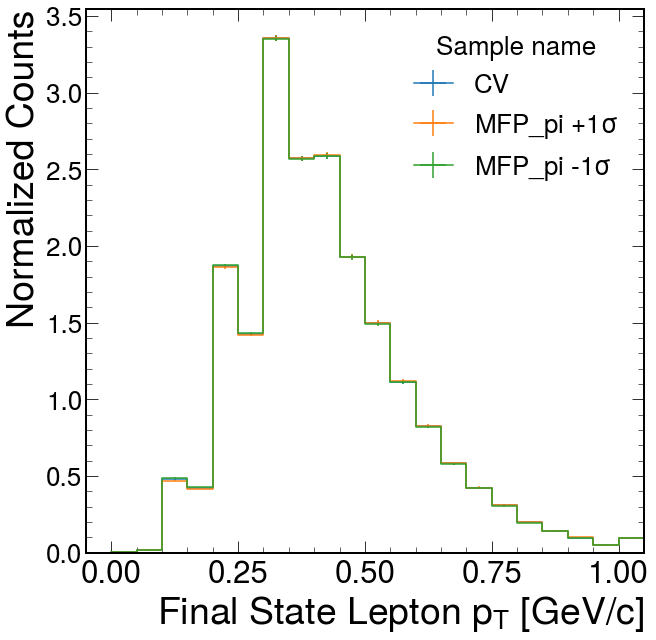

In [6]:
hist.plot1d(hists["lepton_pt"], overflow = 'all', density = True)
l_pt_path = save_path + "lepton_pt_MFP_norm.pdf"
print(l_pt_path)
plt.savefig(l_pt_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021lepton_e_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


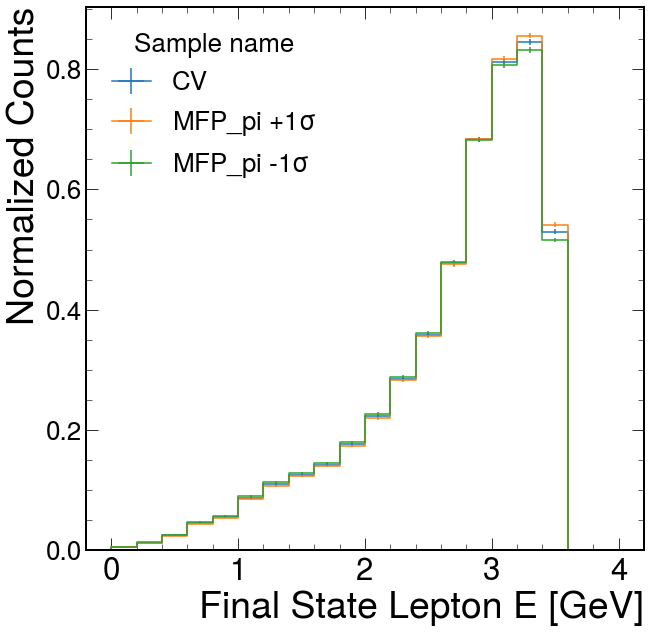

In [7]:
hist.plot1d(hists["lepton_e"], overflow = 'all', density = True)
l_e_path = save_path + "lepton_e_MFP_norm.pdf"
print(l_e_path)
plt.savefig(l_e_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021lepton_theta_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


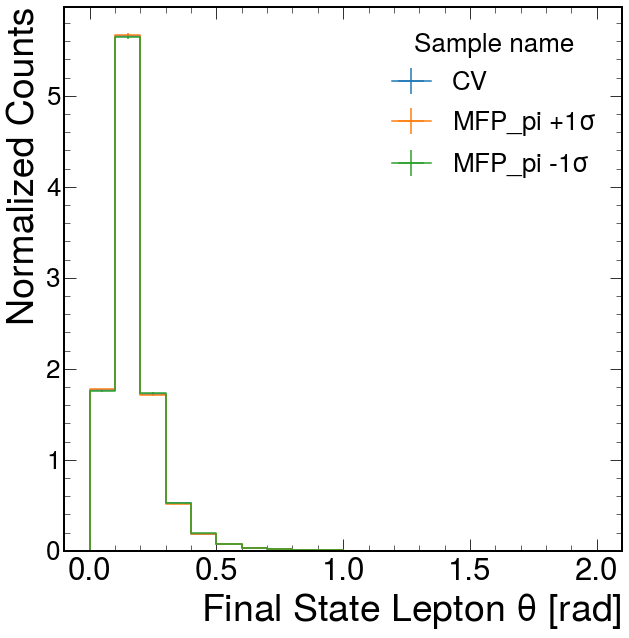

In [8]:
hist.plot1d(hists["lepton_theta"], overflow = 'all', density = True)
l_theta_path = save_path + "lepton_theta_MFP_norm.pdf"
print(l_theta_path)
plt.savefig(l_theta_path, bbox_inches='tight')

## 1.2 Protons

/u/gu/dhoang/ldmx_plot/11-04-2021p1_ke_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


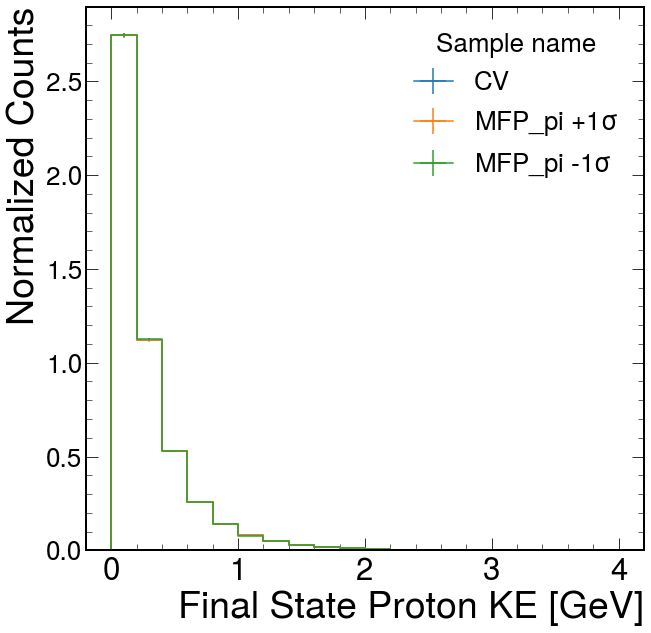

In [10]:
hist.plot1d(hists["p1_ke"], overflow = 'all', density = True)
p1_ke_path = save_path + "p1_ke_MFP_norm.pdf"
print(p1_ke_path)
plt.savefig(p1_ke_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021p1_theta_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


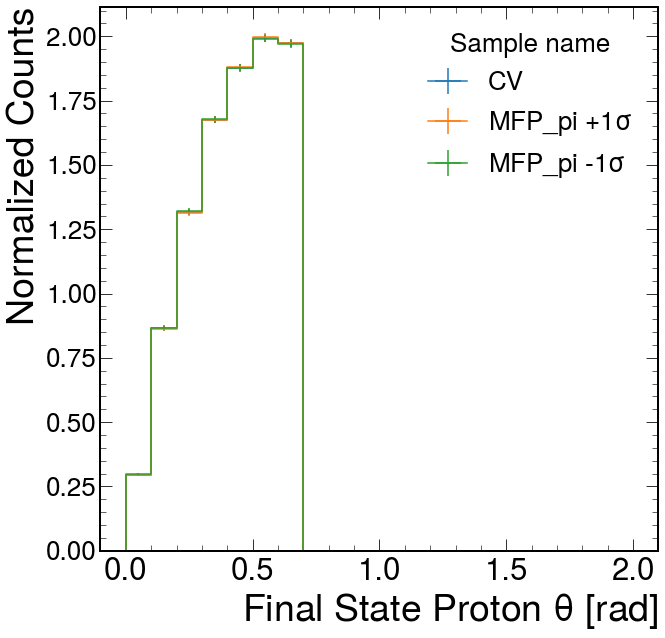

In [11]:
hist.plot1d(hists["p1_theta"], overflow = 'all', density = True)
p1_theta_path = save_path + "p1_theta_MFP_norm.pdf"
print(p1_theta_path)
plt.savefig(p1_theta_path, bbox_inches='tight')

## 1.3 Neutrons

/u/gu/dhoang/ldmx_plot/11-04-2021n1_ke_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


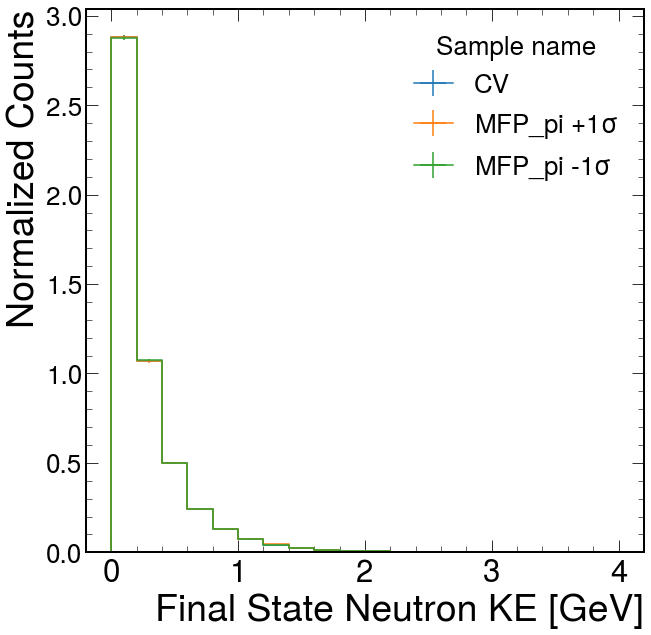

In [12]:
hist.plot1d(hists["n1_ke"], overflow = 'all', density = True)
n1_ke_path = save_path + "n1_ke_MFP_norm.pdf"
print(n1_ke_path)
plt.savefig(n1_ke_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021n1_theta_MFP_norm.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


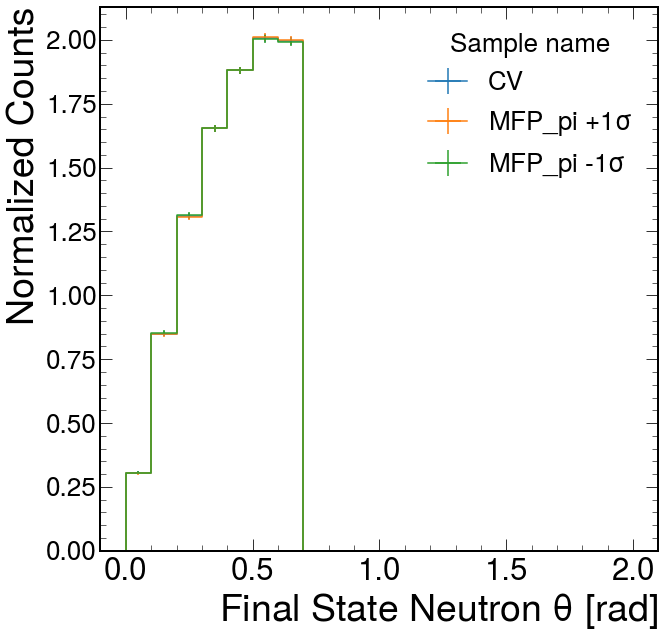

In [13]:
hist.plot1d(hists["n1_theta"], overflow = 'all', density = True)
n1_theta_path = save_path + "n1_theta_MFP_norm.pdf"
print(n1_theta_path)
plt.savefig(n1_theta_path, bbox_inches='tight')

## 2. With electron's $p_T > 400 MeV$ threshold

In [2]:
hists = {}

#Leading lepton stuffs
hists["lepton_pt"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Lepton $p_{T}$ [GeV/c]", 20, 0, 1))
hists["lepton_e"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Lepton E [GeV]", 20, 0, 4))
hists["lepton_theta"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("theta", r"Final State Lepton $\theta$ [rad]", 20, 0, 2))
#Leading proton stuffs
hists["p1_ke"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Proton KE [GeV]", 20, 0, 4))
hists["p1_theta"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("theta", r"Final State Proton $\theta$ [rad]", 20, 0, 2))

#Leading neutron stuffs
hists["n1_ke"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Neutron KE [GeV]", 20, 0, 4))
hists["n1_theta"] = hist.Hist("Normalized Counts", hist.Cat("sample", "Sample name"), 
                               hist.Bin("theta", r"Final State Neutron $\theta$ [rad]", 20, 0, 2))

def processor(file_name, config_mode = 'loose'):
    
    gst_df = pd.read_hdf(file_name, key="gst_df")

    query='index' #all
    df=gst_df.query(query)
    
    #Varibale parameters
    wght="MFP_pi"
    sigma=1
    units="GeV/c"
    
    pt_trigger = (df['ptl'].to_numpy() > 0.4)
    
    #2D trigger simulation
    trigger_weights = df.apply(lambda x: trigger_weight_2D(x.ptl, x.El, mode = config_mode), axis = 1)
    
    CV_weight = (df["wght"]*trigger_weights).to_numpy()[pt_trigger]
    plus_sigma_weight = (df["wght_%s_p%d"%(wght,sigma)]*trigger_weights).to_numpy()[pt_trigger]
    minus_sigma_weight =  (df["wght_%s_n%d"%(wght,sigma)]*trigger_weights).to_numpy()[pt_trigger]
    
    #--------------------LEADING LEPTONS
    #Lepton's pT
    lepton_pt = df['ptl'].to_numpy()[pt_trigger]
    
    hists["lepton_pt"].fill(sample = 'CV', pt = lepton_pt, weight = CV_weight)
    
    hists["lepton_pt"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), pt = lepton_pt,
                            weight= plus_sigma_weight)
    
    hists["lepton_pt"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), pt = lepton_pt,
                            weight= minus_sigma_weight)
    
    #Energy of lepton
    lepton_e = df['El'].to_numpy()[pt_trigger]
    hists["lepton_e"].fill(sample = 'CV', e = lepton_e, weight = CV_weight)
    
    hists["lepton_e"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), e = lepton_e,
                            weight= plus_sigma_weight)
    
    hists["lepton_e"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), e = lepton_e,
                            weight= minus_sigma_weight)
    
    #Lepton angle
    lepton_theta = df['thetal'].to_numpy()[pt_trigger]
    hists["lepton_theta"].fill(sample = 'CV', theta = lepton_theta, weight = CV_weight)
    
    hists["lepton_theta"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), theta = lepton_theta,
                            weight= plus_sigma_weight)
    
    hists["lepton_theta"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), theta = lepton_theta,
                            weight= minus_sigma_weight)
    
    #--------------------LEADING PROTONS
    #Proton Kinetic Energy
    proton_ke = df['ke_p1'].to_numpy()[pt_trigger]
    hists["p1_ke"].fill(sample = 'CV', ke = proton_ke, weight = CV_weight)
    hists["p1_ke"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), ke = proton_ke,
                       weight= plus_sigma_weight)
    hists["p1_ke"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), ke = proton_ke,
                        weight= minus_sigma_weight)
    
    #Proton theta
    p1_theta = df['thetaz_p1'].to_numpy()[pt_trigger]
    hists["p1_theta"].fill(sample = 'CV', theta = p1_theta, weight = CV_weight)
    
    hists["p1_theta"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), theta = p1_theta,
                            weight= plus_sigma_weight)
    
    hists["p1_theta"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), theta = p1_theta,
                            weight= minus_sigma_weight)
    
    #--------------------LEADING NEUTRONs
    #Proton Kinetic Energy
    neutron_ke = df['ke_n1'].to_numpy()[pt_trigger]
    hists["n1_ke"].fill(sample = 'CV', ke = neutron_ke, weight = CV_weight)
    hists["n1_ke"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), ke = neutron_ke,
                       weight= plus_sigma_weight)
    hists["n1_ke"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), ke = neutron_ke,
                        weight= minus_sigma_weight)
    
    #neutron theta
    n1_theta = df['thetaz_n1'].to_numpy()[pt_trigger]
    hists["n1_theta"].fill(sample = 'CV', theta = n1_theta, weight = CV_weight)
    
    hists["n1_theta"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), theta = n1_theta,
                            weight= plus_sigma_weight)
    
    hists["n1_theta"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), theta = n1_theta,
                            weight= minus_sigma_weight)
    
    %reset -f in

In [3]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path)
        
        chunk += 1
#         if chunk == 1:
#             break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


### 2.1 lepton

/u/gu/dhoang/ldmx_plot/11-04-2021lepton_pt_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


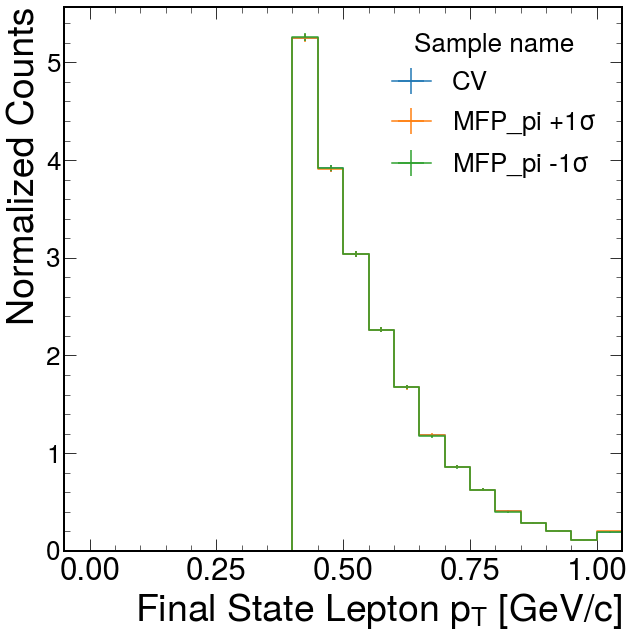

In [4]:
hist.plot1d(hists["lepton_pt"], overflow = 'all', density = True)
l_pt_path = save_path + "lepton_pt_MFP_norm_400trigger.pdf"
print(l_pt_path)
plt.savefig(l_pt_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021lepton_e_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


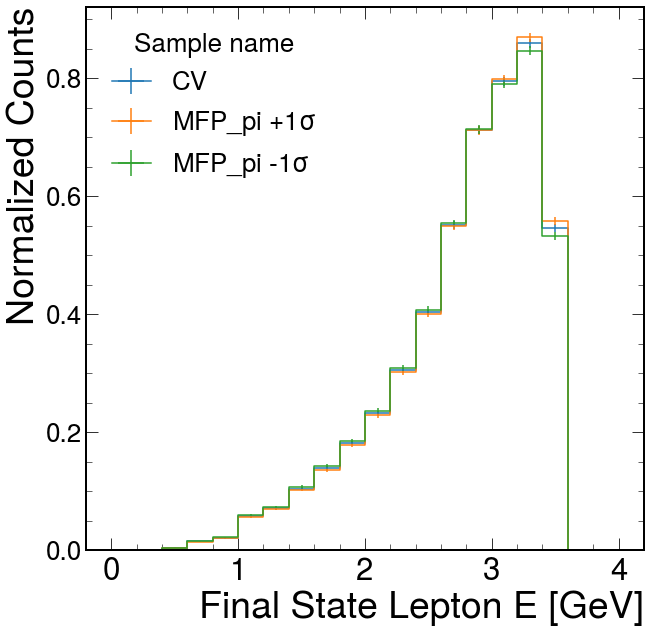

In [5]:
hist.plot1d(hists["lepton_e"], overflow = 'all', density = True)
l_e_path = save_path + "lepton_e_MFP_norm_400trigger.pdf"
print(l_e_path)
plt.savefig(l_e_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021lepton_theta_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


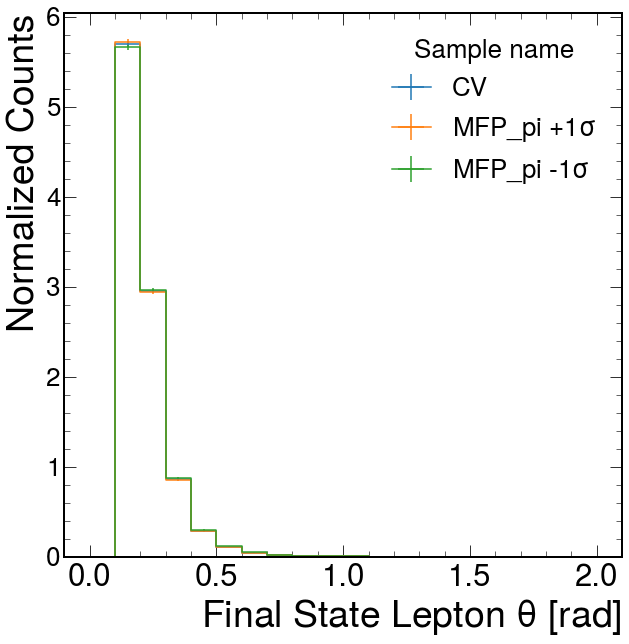

In [6]:
hist.plot1d(hists["lepton_theta"], overflow = 'all', density = True)
l_theta_path = save_path + "lepton_theta_MFP_norm_400trigger.pdf"
print(l_theta_path)
plt.savefig(l_theta_path, bbox_inches='tight')

## 1.2 Protons

/u/gu/dhoang/ldmx_plot/11-04-2021p1_ke_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


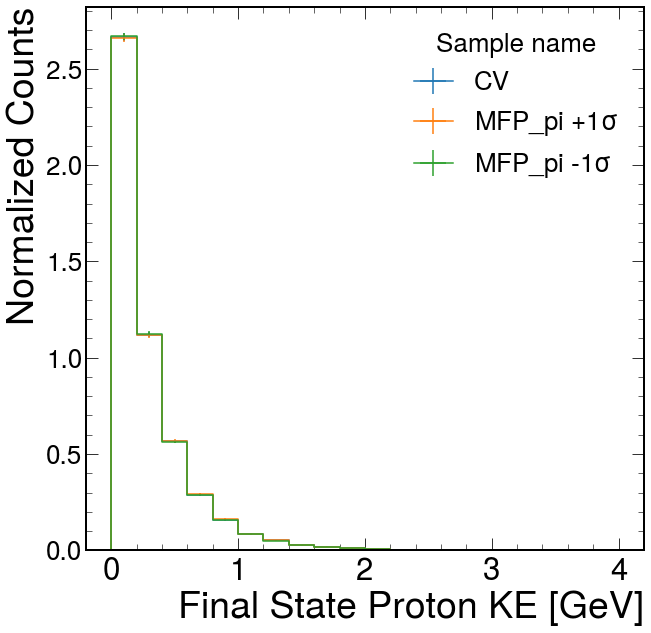

In [7]:
hist.plot1d(hists["p1_ke"], overflow = 'all', density = True)
p1_ke_path = save_path + "p1_ke_MFP_norm_400trigger.pdf"
print(p1_ke_path)
plt.savefig(p1_ke_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021p1_theta_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


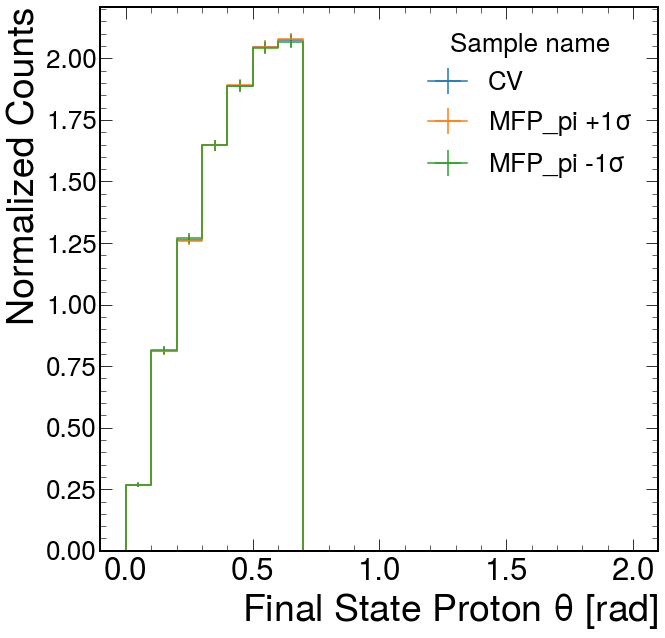

In [8]:
hist.plot1d(hists["p1_theta"], overflow = 'all', density = True)
p1_theta_path = save_path + "p1_theta_MFP_norm_400trigger.pdf"
print(p1_theta_path)
plt.savefig(p1_theta_path, bbox_inches='tight')

## 1.3 Neutrons

/u/gu/dhoang/ldmx_plot/11-04-2021n1_ke_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


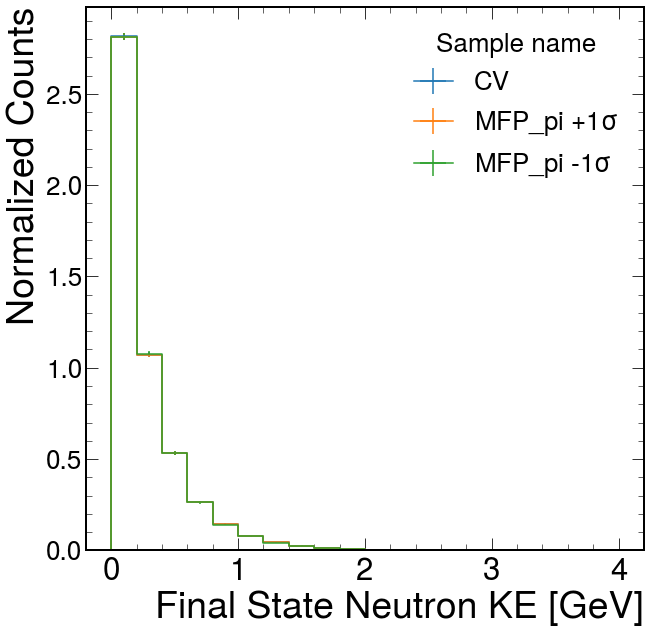

In [9]:
hist.plot1d(hists["n1_ke"], overflow = 'all', density = True)
n1_ke_path = save_path + "n1_ke_MFP_norm_400trigger.pdf"
print(n1_ke_path)
plt.savefig(n1_ke_path, bbox_inches='tight')

/u/gu/dhoang/ldmx_plot/11-04-2021n1_theta_MFP_norm_400trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


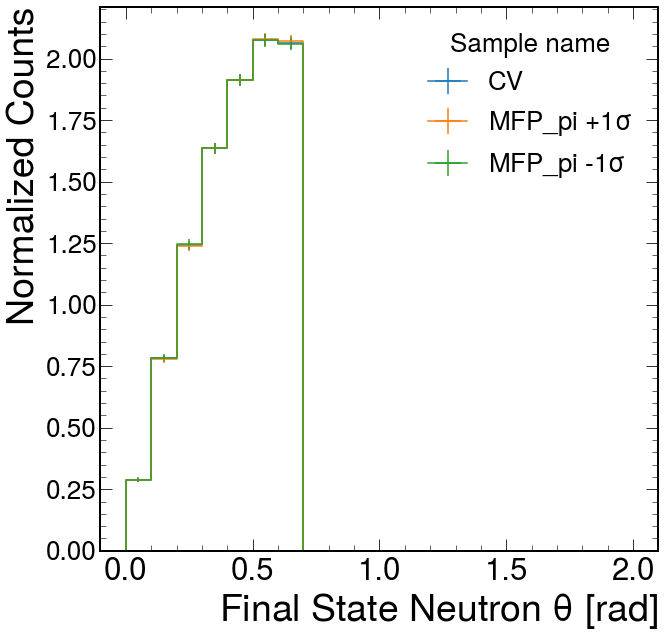

In [10]:
hist.plot1d(hists["n1_theta"], overflow = 'all', density = True)
n1_theta_path = save_path + "n1_theta_MFP_norm_400trigger.pdf"
print(n1_theta_path)
plt.savefig(n1_theta_path, bbox_inches='tight')